In [369]:
import matplotlib
import pandas as pd 
import numpy as np
import json
import os

# making plots
import matplotlib.pyplot as plt
import seaborn as sns

# math + calculations
import datetime
import math
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 100)

%config InlineBackend.figure_format = 'retina'

matplotlib.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12.0, 6.0]

# name of downloaded data folder
folderName = "facebook-mliu42" # EDIT PER PERSON
myName = "Michelle Liu"
# optional feature to track # instances of name/nickname is used in conversation, not case sensitive
myNameList = ["Michelle Liu", "Michelle"] # or None to opt out

In [414]:
# given a message.json file and the directory name it is located within, return the name and members
def getConvoNameAndMembers(messageJson):
    members = []
    for person in messageJson['participants']:
        members.append(person['name'])
    return messageJson['title'], members

# return number of words and number of non-unicode chars in a message (unicode: ', ", emojis, special characters, etc.) 
def calculateCharAndWords(messageString):
    numWords = messageString.count(" ")
    numChars = len(messageString) - messageString.count("\u") * 6 # "\n####" unicode
    return numChars, numWords

# which conversation is the most profane?
def getProfanityCount(messageString):
    count = 0
    profanityList = ["shit", "ass", "fuck", "damn", " hell"]
    for curse in profanityList:
        count += messageString.count(curse)
    return count

# which conversations say my name the most?
def getMyNameCount(messageString):
    global myNameList
    count = 0
    if myNameList:
        for name in myNameList:
            count += messageString.lower().count(name.lower())
    return count

# which conversations are the most positive/negative?
def getSentimentAnalysisScore(messageString):
    return 0

# given a message.json file, return a list of message objects and their stats 
def readMessages(messageJson, conversationStats):
    global myName
    messages = []

    for entry in messageJson['messages']:
        if 'content' in entry:
            if 'First Message Time' not in conversationStats or entry['timestamp_ms'] < conversationStats['First Message Time']:
                conversationStats['First Message Time'] = entry['timestamp_ms']
            if 'Last Message Time' not in conversationStats or entry['timestamp_ms'] > conversationStats['Last Message Time']:
                conversationStats['Last Message Time'] = entry['timestamp_ms']
            
            messageContent = entry['content']
            message = {
                'sender' : entry['sender_name'],
                'timestamp' : entry['timestamp_ms'],
                'content' : messageContent,
                'chatName' : messageJson['title'],
                'date' : datetime.datetime.fromtimestamp(entry['timestamp_ms'] / 1000)
                # reactions, contentType
            }
            messages.append(message)
            
            conversationStats['Num Chars'] += len(messageContent) - messageContent.count("\u") * 6 # "\n####" unicode
            conversationStats['Num Words'] += messageContent.count(" ")
            conversationStats['Num Sent By Me'] += 1 if entry['sender_name'] == myName else 0
            conversationStats['Profanity Count'] += getProfanityCount(messageContent)
            conversationStats['My Name Count'] += getMyNameCount(messageContent)
            
    return messages, conversationStats

In [415]:
# returns df of summary stats and a list of all messages combined
index = 0
def processConversation(convo_dir_path): # path: data/<myFolderName>/messages/inbox/<conversation_name>
    global index
    isFirst = True
    chatName = ""
    members = []
    messages = []
    stats = {
        "Num Chars" : 0,
        "Num Words" : 0,
        "Num Sent By Me" : 0,
        "Profanity Count" : 0,
        "My Name Count" : 0,
    }

    for filename in os.listdir(convo_dir_path): # iterate through all files
        if filename[:7] == 'message': # read only message.json files
            with open(convo_dir_path + '/' + filename) as f:
                messageJson = json.load(f)
            if isFirst: # set chat name and members only once
                chatName, members = getConvoNameAndMembers(messageJson)
                isFirst = False
            # update messageList and conversation stats for each message.json file
            newMessages, stats = readMessages(messageJson, stats)
            messages += newMessages

    # check if is interesting-- <= 12 members, > 2 messages, no deleted users ("Facebook User")
    if len(members) <= 12 and not "Facebook User" in members and len(messages) > 2:
        # add identifying info
        index += 1
        stats['Chat ID'] = index - 1
        stats['Chat Name'] = chatName
        stats['Chat Members'] = members
        stats['Num Messages'] = len(messages)
        stats['Directory Name'] = convo_dir_path[convo_dir_path.rfind('/') + 1:]
        return stats, messages
    else:
        return None, None

def processAllConversations(directoryPath, MAX_NUM_PROCESS=-1): # path: data/<myFolderName>/messages/inbox
    summaryTable = pd.DataFrame()
    allMessages = []
    messagesTable = pd.DataFrame()
    
    index = 0
    for item in os.listdir(directoryPath): # iterate through all subdirectories
        convo_dir_path = directoryPath + '/' + item
        if os.path.isdir(convo_dir_path): # check is valid conversation folder
            stats, messages = processConversation(convo_dir_path) # returns (None, None) if not interesting
            if stats and (index < MAX_NUM_PROCESS or MAX_NUM_PROCESS == -1):
                index += 1
                if index % 20 == 0:
                    print("Processing conversation: " + str(index))
                elif index % 10 == 0:
                    print("|"),
                else:
                    print("."),
                messagesTable = messagesTable.append(messages, ignore_index=True)
#                 allMessages += messages
                summaryTable = summaryTable.append(stats, ignore_index=True)
    print("Finished processing all conversations ☺️")

    return messagesTable, summaryTable

In [751]:
directoryPath = 'data/' + folderName + '/messages/inbox'
messagesTable, summaryTable = processAllConversations(directoryPath)

. . . . . . . . . | . . . . . . . . . Processing conversation: 20
. . . . . . . . . | . . . . . . . . . Processing conversation: 40
. . . . . . . . . | . . . . . . . . . Processing conversation: 60
. . . . . . . . . | . . . . . . . . . Processing conversation: 80
. . . . . . . . . | . . . . . . . . . Processing conversation: 100
. . . . . . . . . | . . . . . . . . . Processing conversation: 120
. . . . . . . . . | . . . . . . . . . Processing conversation: 140
. . . . . . . . . | . . . . . . . . . Processing conversation: 160
. . . . . . . . . | . . . . . . . . . Processing conversation: 180
. . . . . . . . . | . . . . . . . . . Processing conversation: 200
. . . . . . . . . | . . . . . . . . . Processing conversation: 220
. . . . . . . . . | . . . . . . . . . Processing conversation: 240
. . . . . . . . . | . . . . . . . . . Processing conversation: 260
. . . . . . . . . | . . . . . . . . . Processing conversation: 280
. . . . . . . . . | . . . . . . . . . Processing conversation: 300

In [752]:
summaryTable.sort_values('Num Messages', ascending=False)

,Chat ID,Chat Members,Chat Name,Directory Name,First Message Time,Last Message Time,My Name Count,Num Chars,Num Messages,Num Sent By Me,Num Words,Profanity Count
75,585.0,"[Raymond Zhu, Michelle Liu]",Raymond Zhu,RaymondZhu_2kSZBqr4fg,1.471645e+12,1.588263e+12,508.0,3180821.0,139345.0,61608.0,539229.0,3247.0
15,525.0,"[Amy Hu, Michelle Liu]",Amy Hu,AmyHu_Mn8zlmbfVA,1.301791e+12,1.588268e+12,5151.0,2817070.0,129948.0,61147.0,451151.0,1520.0
67,577.0,"[Eric Wang, Michelle Liu]",Eric Wang,EricWang_TVv33syrTA,1.548692e+12,1.583720e+12,185.0,1706802.0,60527.0,28586.0,297235.0,1196.0
628,1138.0,"[Jeremy Zou, Michelle Liu]",Jeremy Zou,JeremyZou_JOvOphA4Xg,1.368333e+12,1.543119e+12,397.0,592694.0,28924.0,15330.0,93925.0,252.0
408,918.0,"[Junho Park, Michelle Liu]",Junho Park,JunhoPark_iOlzZekT-w,1.337803e+12,1.588127e+12,232.0,571474.0,27960.0,12412.0,84150.0,368.0
85,595.0,"[Minji Kim, Soo Kim, Amanda Zhang, Michelle Li...",Band Squad ð,BandSquad_VJy_gO-RmA,1.495037e+12,1.583940e+12,334.0,634262.0,24094.0,1563.0,104720.0,789.0
558,1068.0,"[Michelle Tzeng, Michelle Liu]",Michelle Tzeng,MichelleTzeng_SKcaQeZAFg,1.523669e+12,1.587738e+12,87.0,701586.0,22381.0,12553.0,125904.0,659.0
313,823.0,"[Emily Wang, Michelle Liu]",Emily Wang,EmilyWang_tIAnealEbQ,1.513127e+12,1.588198e+12,56.0,557915.0,19864.0,9707.0,95216.0,452.0
375,885.0,"[Daniel Kim, Michelle Liu]",Daniel Kim,DanielKim_6KMXGL9NIQ,1.348613e+12,1.588045e+12,169.0,469898.0,19562.0,8799.0,77634.0,454.0
26,536.0,"[Joseph Zhang, Michelle Liu]",Joseph Zhang,JosephZhang_0nB6hClmuw,1.344434e+12,1.583025e+12,80.0,417586.0,19368.0,8807.0,68743.0,452.0


In [756]:
# additional summary table processing
summaryTable['Num Sent By Them'] = summaryTable['Num Messages'] - summaryTable['Num Sent By Me']
summaryTable['Percent Sent By Me'] = summaryTable['Num Sent By Me'] / summaryTable['Num Messages']
summaryTable['Profanity %'] = summaryTable['Profanity Count'] / summaryTable['Num Words'] * 100
summaryTable['Total Chat Length (days)'] = (summaryTable['Last Message Time'] - summaryTable['First Message Time']) / (60000 * 60 * 24)
summaryTable['Chat Density'] = summaryTable['Num Messages'] / summaryTable['Total Chat Length (days)']

# additional messages table processing
messagesTable['Month/Year'] = messagesTable['date'].apply(lambda x: datetime.date(x.year, x.month, 1))

# messagesTable
summaryTable.sort_values('Num Messages', ascending=False)[:25]

,Chat ID,Chat Members,Chat Name,Directory Name,First Message Time,Last Message Time,My Name Count,Num Chars,Num Messages,Num Sent By Me,Num Words,Profanity Count,Num Sent By Them,Percent Sent By Me,Profanity %,Total Chat Length (days),Chat Density
75,585.0,"[Raymond Zhu, Michelle Liu]",Raymond Zhu,RaymondZhu_2kSZBqr4fg,1.471645e+12,1.588263e+12,508.0,3180821.0,139345.0,61608.0,539229.0,3247.0,77737.0,0.442126,0.602156,1349.749001,103.237713
15,525.0,"[Amy Hu, Michelle Liu]",Amy Hu,AmyHu_Mn8zlmbfVA,1.301791e+12,1.588268e+12,5151.0,2817070.0,129948.0,61147.0,451151.0,1520.0,68801.0,0.470550,0.336916,3315.709220,39.191615
67,577.0,"[Eric Wang, Michelle Liu]",Eric Wang,EricWang_TVv33syrTA,1.548692e+12,1.583720e+12,185.0,1706802.0,60527.0,28586.0,297235.0,1196.0,31941.0,0.472285,0.402375,405.413119,149.297093
628,1138.0,"[Jeremy Zou, Michelle Liu]",Jeremy Zou,JeremyZou_JOvOphA4Xg,1.368333e+12,1.543119e+12,397.0,592694.0,28924.0,15330.0,93925.0,252.0,13594.0,0.530010,0.268299,2022.986762,14.297671
408,918.0,"[Junho Park, Michelle Liu]",Junho Park,JunhoPark_iOlzZekT-w,1.337803e+12,1.588127e+12,232.0,571474.0,27960.0,12412.0,84150.0,368.0,15548.0,0.443920,0.437314,2897.267907,9.650471
85,595.0,"[Minji Kim, Soo Kim, Amanda Zhang, Michelle Li...",Band Squad ð,BandSquad_VJy_gO-RmA,1.495037e+12,1.583940e+12,334.0,634262.0,24094.0,1563.0,104720.0,789.0,22531.0,0.064871,0.753438,1028.975642,23.415520
558,1068.0,"[Michelle Tzeng, Michelle Liu]",Michelle Tzeng,MichelleTzeng_SKcaQeZAFg,1.523669e+12,1.587738e+12,87.0,701586.0,22381.0,12553.0,125904.0,659.0,9828.0,0.560878,0.523415,741.546695,30.181511
313,823.0,"[Emily Wang, Michelle Liu]",Emily Wang,EmilyWang_tIAnealEbQ,1.513127e+12,1.588198e+12,56.0,557915.0,19864.0,9707.0,95216.0,452.0,10157.0,0.488673,0.474710,868.877869,22.861671
375,885.0,"[Daniel Kim, Michelle Liu]",Daniel Kim,DanielKim_6KMXGL9NIQ,1.348613e+12,1.588045e+12,169.0,469898.0,19562.0,8799.0,77634.0,454.0,10763.0,0.449801,0.584795,2771.198615,7.059039
26,536.0,"[Joseph Zhang, Michelle Liu]",Joseph Zhang,JosephZhang_0nB6hClmuw,1.344434e+12,1.583025e+12,80.0,417586.0,19368.0,8807.0,68743.0,452.0,10561.0,0.454719,0.657521,2761.473088,7.013648


In [758]:
summaryTable.loc[summaryTable['Directory Name'] == 'QGzeE8fYHg']['Chat Name'].iloc[0]

u'\xf0\x9f\x91\x85\xf0\x9f\x92\xa6\xf0\x9f\x91\x80'

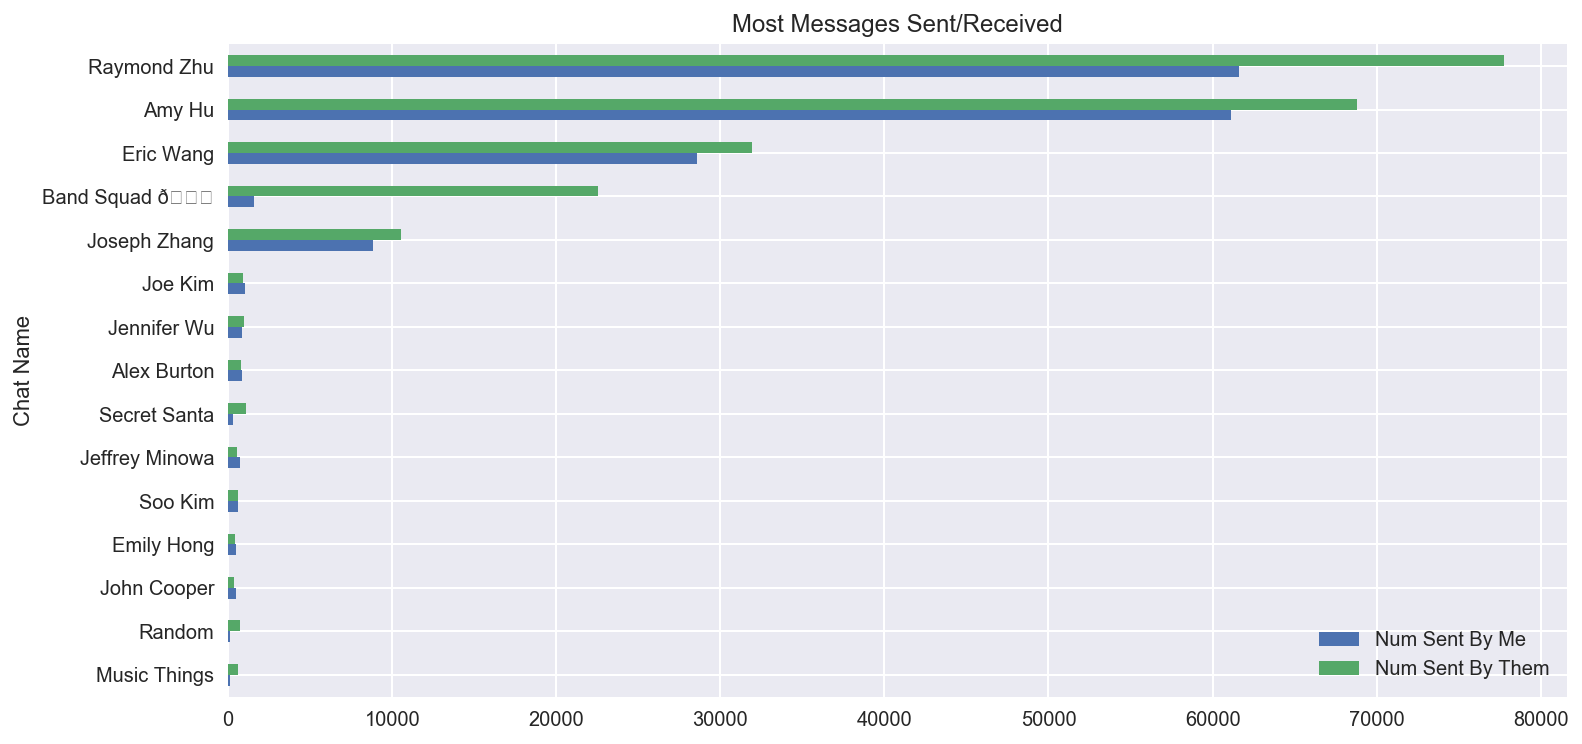

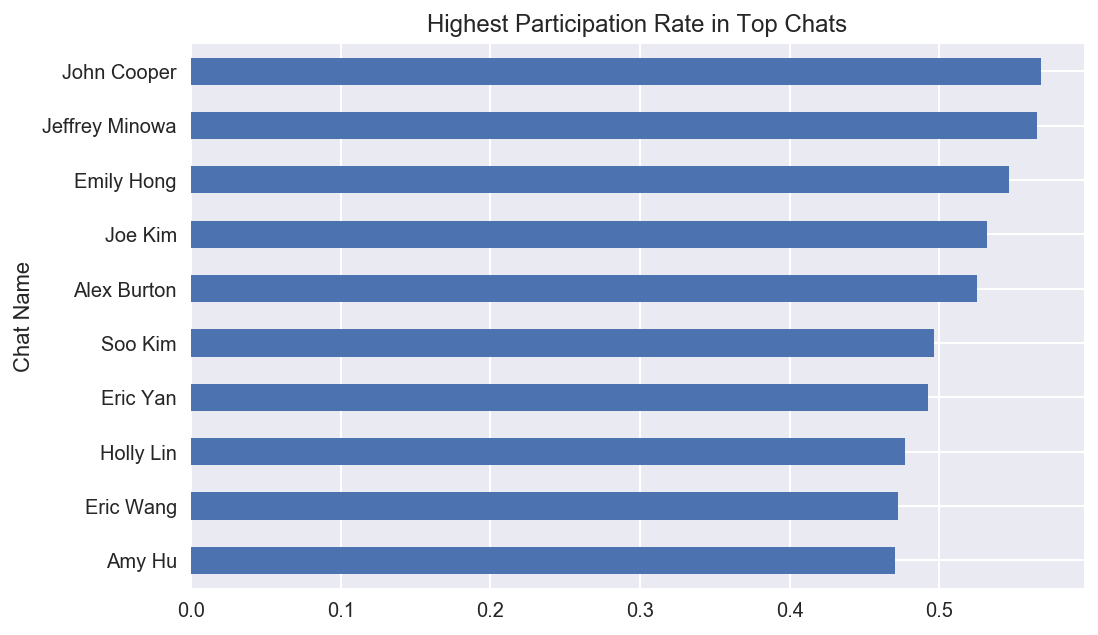

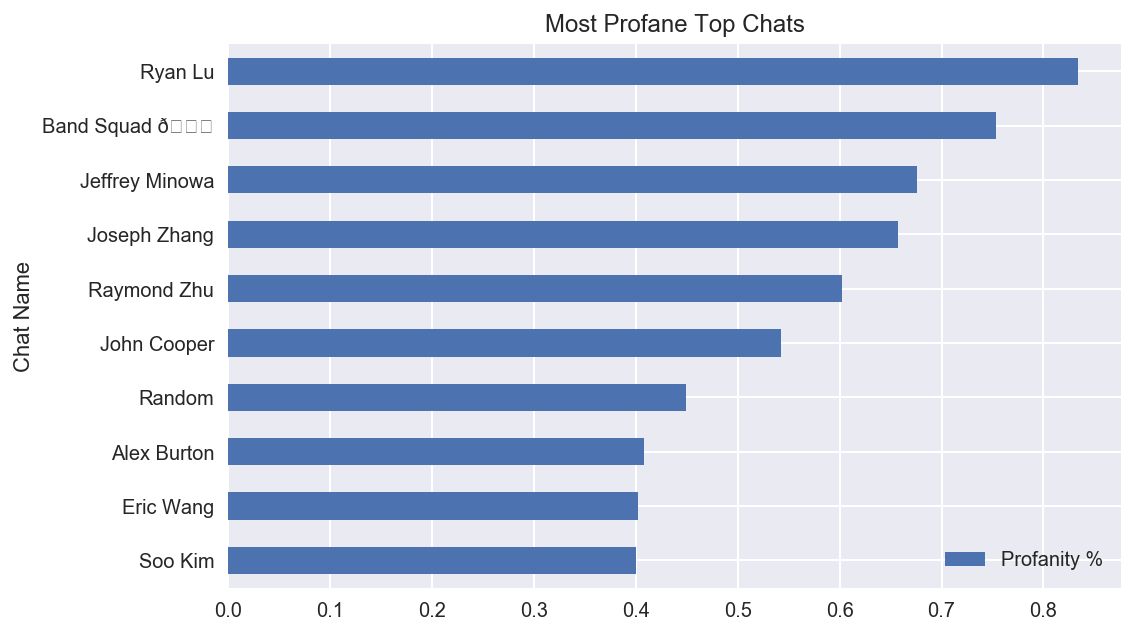

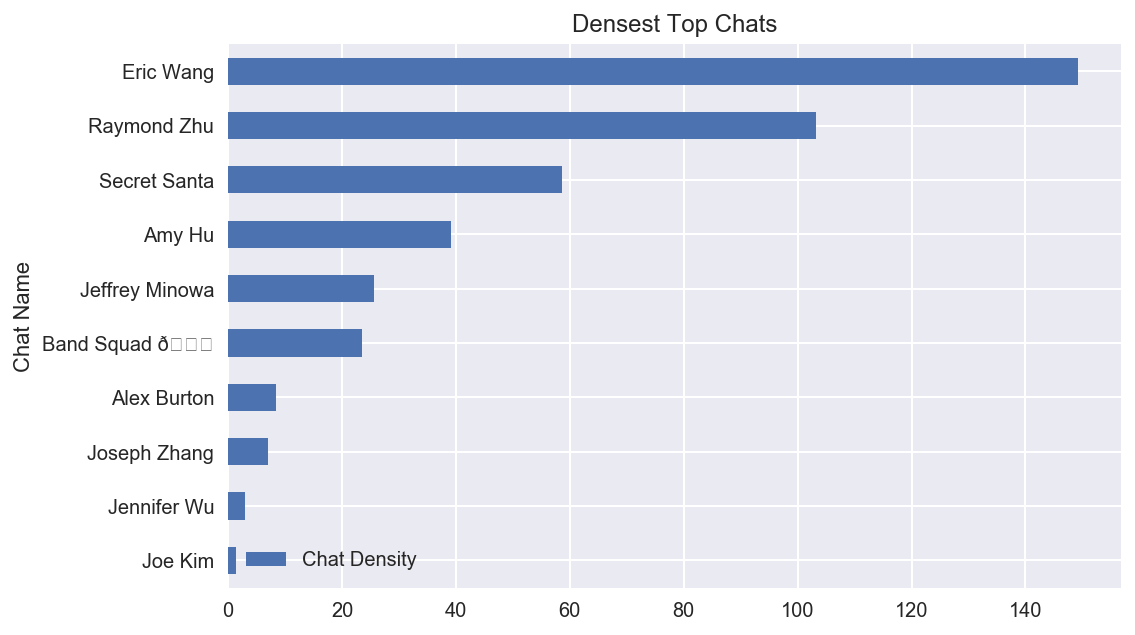

In [432]:
topTwentyMost = summaryTable.sort_values('Num Messages', ascending=False)[:20]
topTwentyMost[:15].sort_values('Num Messages', ascending=True).plot(
    x=['Chat Name'], y=['Num Sent By Me', 'Num Sent By Them'], kind="barh", title="Most Messages Sent/Received")

# Of top chats, what is my highest participation? (pre-filtered by top 20 bc low # samples -> not representative)
topTwentyMost.sort_values('Percent Sent By Me', ascending=True)[10:20].plot(
    x=['Chat Name'], y=['Percent Sent By Me'], kind="barh", 
    title="Highest Participation Rate in Top Chats", figsize=(8,5), legend=False)

# Of top chats, which chats are the most profane? (pre-filtered by top 20 bc low # samples -> not representative)
topTwentyMost.sort_values('Profanity %', ascending=True)[10:20].plot(
    x=['Chat Name'], y=['Profanity %'], kind="barh", 
    title="Most Profane Top Chats", figsize=(8,5), legend=True)

# Of top chats, which chats are the most dense? (pre-filtered by top 10 bc low # samples -> not representative)
topTwentyMost[:10].sort_values('Chat Density', ascending=True).plot(
    x=['Chat Name'], y=['Chat Density'], kind="barh", 
    title="Densest Top Chats", figsize=(8,5))

plt.show()

In [435]:
messagesTable
# summaryTable.sort_values('Num Messages', ascending=False)

,chatName,content,date,sender,timestamp,Month/Year
0,GT Final Failures,Same ð,2017-05-08 18:24:36.710,Amanda Zhang,1494282276710,2017-05-01
1,GT Final Failures,Sameeee ððð,2017-05-08 18:22:32.159,Jasmin Gao,1494282152159,2017-05-01
2,GT Final Failures,still got a weighted A,2017-05-08 18:18:08.241,Animesh Koratana,1494281888241,2017-05-01
3,GT Final Failures,21/40 on the frq ððð,2017-05-08 17:06:03.686,Animesh Koratana,1494277563686,2017-05-01
4,GT Final Failures,RIPPPP,2017-05-08 16:55:57.396,Michelle Liu,1494276957396,2017-05-01
5,GT Final Failures,Damn it I'll just email Martin then,2017-05-08 15:11:15.248,Amanda Zhang,1494270675248,2017-05-01
6,GT Final Failures,â ï¸ð,2017-05-08 15:11:07.428,Amanda Zhang,1494270667428,2017-05-01
7,GT Final Failures,no i dont think so lol,2017-05-08 14:39:51.075,Michelle Liu,1494268791075,2017-05-01
8,GT Final Failures,Wait did u guys get ubexcused for that day,2017-05-08 13:38:22.491,Amanda Zhang,1494265102491,2017-05-01
9,GT Final Failures,Wait it disappeared,2017-05-07 15:34:23.990,Amanda Zhang,1494185663990,2017-05-01


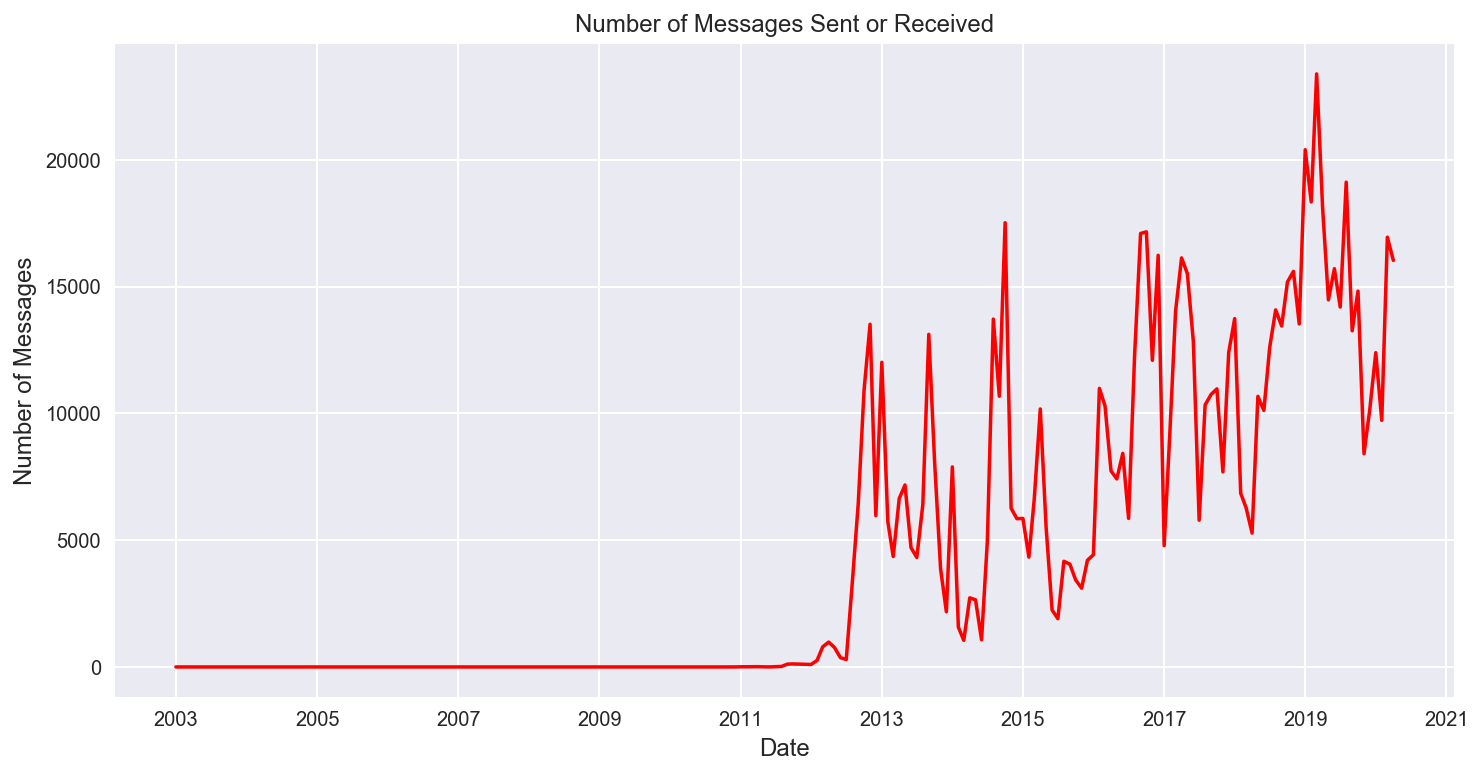

In [408]:
messagesByMonthYear = messagesTable.groupby('Month/Year').count()[['content']].rename(columns={'content' : "Num Messages"})
graph = plt.plot(messagesByMonthYear, 'r-')
plt.title('Number of Messages Sent or Received')
plt.ylabel('Number of Messages', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.show()

In [383]:
# topTwentyMost

In [402]:
def getMessageHistoryByChatName(chatName):
    global messagesTable
    return messagesTable.loc[messagesTable['chatName'] == chatName].groupby('Month/Year').count()[['content']].rename(columns={'content' : "Num Messages"})

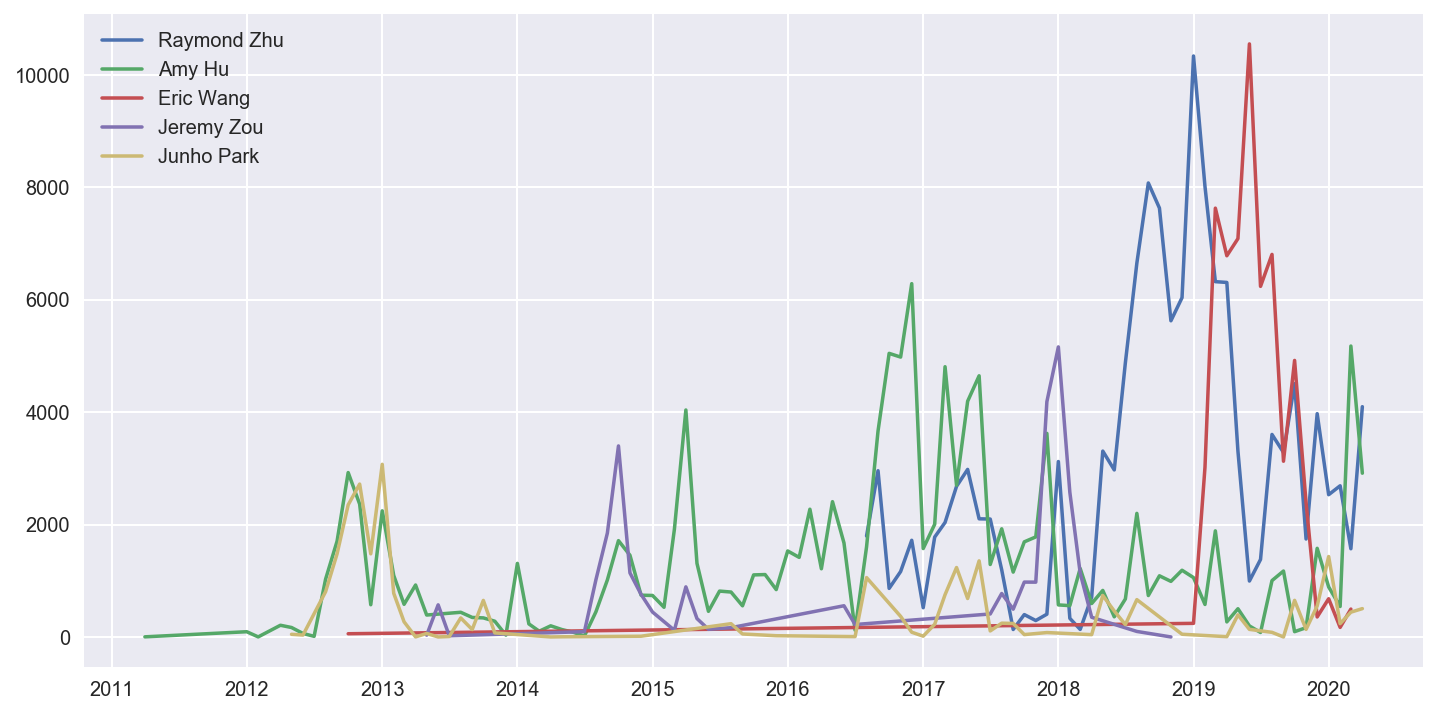

In [403]:
# Plot Top Chats over time
topFiveChatNames = topTwentyMost['Chat Name'][:5]
for chatName in topFiveChatNames:
    plt.plot(getMessageHistoryByChatName(chatName))
plt.legend(topFiveChatNames)
plt.show()

In [718]:
import gensim.downloader as gs
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import gensim.parsing.preprocessing as preprocessing

from string import ascii_letters, digits

In [729]:
## tf-idf processing
# data cleaning helper methods
def isInterestingWord(word):
    if set(word).difference(ascii_letters + digits):
        return False
    
    contractions = ['dont', 'doesnt', 'wont', 'cant', 'couldnt', 
                    'shouldnt', 'yall', 'isnt', 'wasnt','couldve', 
                    'wouldve','shouldve', 'im', 'its']
    abbreviations = ['thru', 'bc', 'idk', 'ur', 'hf', 'lol', 'ok', 'np', 'tbh', 'tbf', 'btw', 'nah', 'okey', 
                     'tmr', 'tn', 'sure', 'prob', 'said', 'tho', 'lmao', 'tho', 'its', 'ya', 'yah', 'rly', 
                     'ye', 'mm', 'ic', 'np']
    commonMispellings = ['juts', 'tahts']
    return word not in contractions and word not in abbreviations and word not in commonMispellings and len(word) > 1 and len(word) < 30 and not '\'' in word

def clean(data):
    # string processing
    data = data.lower()
    data = preprocessing.remove_stopwords(data)
    symbols = "!@#$%^&*()_+-=:\/<>,.?[]{}|~"
    for symbol in symbols:
        data = data.replace(symbol, "")   
    words = data.split()
    return [word for word in words if isInterestingWord(word)]

In [730]:
# format df of messages to list of documents
# given a df containing all relevant messages, generate list of (columnValue, messageString) tuples 
def getMessageListByColumn(messageTable, colName):
    distinctGroups = messageTable[colName].drop_duplicates()
    messagesByGroup = []
    for group in distinctGroups:
        allMessages = ""
        for content in messageTable.loc[messageTable[colName] == group]['content']:
            allMessages += content + " "
        messagesByGroup.append((group, allMessages))
    return messagesByGroup

# given table of relevent messages and the group to split them on (default 'Month/Year'),
# return list of {"colName" : GroupValue, "Top Words": [(index, word, tf-idf ranking)]}
def getSignificantWords(messageTable, colName="Month/Year"):
    messageList = getMessageListByColumn(messageTable, colName)
    dataset = [clean(data) for data in (messageInfo[1] for messageInfo in messageList)]
    dct = Dictionary(dataset)
    corpus = [dct.doc2bow(line) for line in dataset]
    model = TfidfModel(corpus)
    
    topWordsByGroup = []
    for i in range(len(dataset)):
        vector = model[corpus[i]]
        sortedTuples = sorted(vector, key=lambda item:item[1], reverse=True) # sort by rank
        formattedTuples = [(word[0], dct[word[0]], word[1]) for word in sortedTuples] # add "translated" word for readability
        topWordsByGroup.append({
            colName : messageList[i][0],
            "Top Words" : formattedTuples
        })
    
    return topWordsByGroup

# format significant words object to readable df
# sigWords: {"colName" : GroupValue, "Top Words": [(index, word, tf-idf ranking)]}
def formatSignificantWordsToDF(sigWords, num_words_to_show=10):
    prettyTable = pd.DataFrame()
    groupName = sigWords[0].keys()[0]
    row = {}
    
    for entry in sigWords:
        row[groupName] = entry['Month/Year']
        for i in range(min(num_words_to_show, len(entry['Top Words']))):
            index, word, rank = entry['Top Words'][i]
            row["Word " + str(i)] = word + " (" + str(round(rank, 3)) + ")"
        prettyTable = prettyTable.append(row, ignore_index=True)
    return prettyTable

In [760]:
# view the tf-idf for my messages all-time grouped by month
myMessages = messagesTable.loc[messagesTable['sender'] == myName]
mySigWordsByMonth = getSignificantWords(myMessages, colName='Month/Year')
myMessagesDF = formatSignificantWordsToDF(mySigWordsByMonth)

myMessagesDF.sort_values('Month/Year', ascending=False).to_csv('my_chats.csv', index=False)
myMessagesDF.sort_values('Month/Year', ascending=False)
# myMessagesDF.sort_values('Month/Year', ascending=False)

,Month/Year,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
87,2020-04-01,remote (0.279),barrys (0.231),quarantine (0.176),bog (0.164),rmr (0.125),like (0.125),zoom (0.105),ops (0.101),exec (0.099),yikes (0.093)
88,2020-03-01,coronavirus (0.187),quarantine (0.178),tiktok (0.176),barrys (0.17),carcassonne (0.143),rmr (0.128),yikes (0.114),ig (0.11),like (0.106),connor (0.099)
89,2020-02-01,barrys (0.278),gai (0.199),bog (0.179),path (0.177),dest (0.176),tg (0.098),agent (0.095),wine (0.094),like (0.093),ig (0.091)
31,2020-01-01,barrys (0.261),bog (0.245),heritage (0.193),rmr (0.171),ig (0.134),like (0.108),jeffs (0.101),mixer (0.101),eric (0.097),tg (0.092)
38,2019-12-01,pcb (0.232),ig (0.196),bog (0.133),cocktails (0.115),classpass (0.115),like (0.112),31st (0.111),jeff (0.104),sry (0.098),springer (0.09)
39,2019-11-01,bog (0.215),demo (0.141),asana (0.122),ig (0.121),tg (0.113),lib (0.108),polynomial (0.102),awh (0.097),seattle (0.097),managers (0.095)
40,2019-10-01,interview (0.341),interviews (0.156),msoft (0.125),mmm (0.123),babe (0.112),expo (0.11),ig (0.107),gre (0.102),hackgt (0.099),rn (0.098)
41,2019-09-01,theta (0.162),interview (0.158),rn (0.155),okeyy (0.135),garage (0.117),coding (0.117),culc (0.11),kbai (0.103),ig (0.102),babe (0.1)
42,2019-08-01,bog (0.212),tg (0.166),okeyy (0.159),theta (0.135),interviews (0.128),sry (0.113),rn (0.112),awh (0.111),babe (0.11),ig (0.109)
43,2019-07-01,rene (0.247),lyft (0.193),bog (0.175),uber (0.162),tg (0.129),intern (0.126),like (0.121),ig (0.12),eric (0.117),sry (0.103)


In [759]:
# view the tf-idf for all messages in a specific chat
queryMessages = messagesTable.loc[messagesTable['chatName'] == u'\xf0\x9f\x91\x85\xf0\x9f\x92\xa6\xf0\x9f\x91\x80']
sigWordsByMonth = getSignificantWords(queryMessages, colName='Month/Year')
queryMessagesDF = formatSignificantWordsToDF(sigWordsByMonth)
queryMessagesDF.sort_values('Month/Year', ascending=False).to_csv('thirst_squad_chats.csv', index=False)

queryMessagesDF.sort_values('Month/Year', ascending=False)

,Month/Year,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
7,2020-04-01,zoom (0.45),bluejeans (0.368),june (0.316),ahaha (0.261),jcatl (0.184),orig (0.184),platform (0.184),prints (0.184),remote (0.184),bentley (0.165)
8,2020-02-01,loop (0.399),atl (0.268),518 (0.199),621 (0.199),bappen (0.199),eeep (0.199),gory (0.199),parasite (0.199),shorten (0.199),spoilers (0.199)
9,2019-08-01,existed (0.452),theeee (0.452),youngjooooooooooon (0.452),sf (0.286),airport (0.286),omw (0.286),randomly (0.237),atl (0.202),ran (0.175),forgot (0.098)
10,2019-05-01,acapella (0.344),cali (0.344),fb (0.199),cs (0.197),817 (0.172),august (0.172),company (0.172),department (0.172),howwhy (0.172),louisville (0.172)
11,2019-04-01,sf (0.223),253 (0.177),amsterdam (0.177),apart (0.177),collide (0.177),continental (0.177),frens (0.177),juicy (0.177),kmpg (0.177),kpmg (0.177)
12,2019-02-01,appearance (0.296),hahhahahahah (0.296),isabel (0.296),rippppppp (0.296),bf (0.246),wheel (0.241),appreciate (0.241),friendly (0.241),cuddle (0.209),hahahahha (0.209)
13,2019-01-01,tinder (0.358),swiped (0.303),trevor (0.247),bio (0.21),kyle (0.202),matched (0.165),swipe (0.165),dreams (0.143),flute (0.126),2019 (0.101)
14,2018-12-01,24th (0.18),army (0.18),finals (0.17),cook (0.147),training (0.127),egg (0.127),def (0.121),maggie (0.114),anything (0.114),basic (0.114)
15,2018-11-01,michael (0.32),tinder (0.317),mon (0.272),nonprofit (0.192),swipe (0.156),age (0.136),winter (0.136),adam (0.128),filmed (0.128),housing (0.128)
16,2018-10-01,fri (0.289),depending (0.276),drunkenly (0.276),junwooooo (0.276),scheduled (0.225),junwoohoo (0.225),midterms (0.225),free (0.21),mon (0.195),friday (0.175)
